<a href="https://colab.research.google.com/github/Nithinps021/Project_IISU/blob/main/Chatbot_retrieval_gru_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieval based chatbot using GRU Algorithm

In [ ]:
import numpy as np
import random
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Bidirectional, Dropout, Dense, Activation, Flatten, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import SGD

#### **STEP 1**
> Load the dataset and shuffle it. 

In [ ]:
data_file = open('is_train.json').read()
intents = json.loads(data_file)
random.shuffle(intents)

#### **STEP 2** 

> Identify the classes present in the dataset set. Create two numpy array to store data and labels. The shape of the label array will be [ dataset_size X number_of_classes ] and default values will be zero. After creating these two arrays go through the dataset and append the text to the data array (*x_train*) and change the value of the column that correspond to the label as 1 (*y_train*).



In [ ]:
classes=[]
for i in intents:
  if i[1] not in classes:
    classes.append(i[1])

tot_data=len(intents)
tot_classes=len(classes)
x_train=np.array([])
y_train=np.zeros(shape=(tot_data,tot_classes), dtype=np.uint8)
for i in range(tot_data):
  x_train=np.append(x_train,intents[i][0])
  y_train[i][classes.index(intents[i][1])]=1

### **STEP 3**


> Create a tokenizer object and pass our text data to the tokenizer. This allow to vectorize a text corpus, by turning each text into a vector where the coefficient for each token based on ***tfidf***


In [ ]:
text=x_train
Tokenizer = Tokenizer(mode='tfidf')
Tokenizer.fit_on_texts(text) 
Tokenizer_vocab_size = len(Tokenizer.word_index) + 1
Tokenizer_vocab_size, x_train.shape, y_train.shape

(5230, (15000,), (15000, 150))

### **STEP 4**


> Splitting the dataset to training set and validation set







In [ ]:
x_val=x_train[0:1500]
y_val=y_train[0:1500]

x_train=x_train[1500:]
y_train=y_train[1500:]


### **STEP 5**


> Converting the text sentence to vectors. After converting to vectors zeros are appended at the front to make dimension equal.






In [25]:
X_train_encoded_words = Tokenizer.texts_to_sequences(x_train)
X_val_encoded_words = Tokenizer.texts_to_sequences(x_val)
X_train_encoded_padded_words = sequence.pad_sequences(X_train_encoded_words, maxlen = 100)
X_val_encoded_padded_words = sequence.pad_sequences(X_val_encoded_words, maxlen = 100)

In [26]:
X_train_encoded_padded_words

array([[   0,    0,    0, ...,   75,   40, 1978],
       [   0,    0,    0, ...,    9,   15,  404],
       [   0,    0,    0, ...,    0,  426,  879],
       ...,
       [   0,    0,    0, ...,   57,  950, 1609],
       [   0,    0,    0, ..., 2035,   48, 1547],
       [   0,    0,    0, ...,    2,   12,   34]], dtype=int32)

### **STEP 6**

> Create Model

In [27]:

model = Sequential()

model.add(Embedding(Tokenizer_vocab_size, 32, input_length = 100)) # Accepts the vector inputs

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32))) 
model.add(Dropout(0.5))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(150, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 32)           167360    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               12672     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 800)               52000     
                                                                 
 dropout_10 (Dropout)        (None, 800)               0         
                                                                 
 dense_10 (Dense)            (None, 200)               160200    
                                                      

In [28]:
Nadam = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
model.compile(loss='categorical_crossentropy', optimizer=Nadam, metrics=['accuracy'])

history  = model.fit(X_train_encoded_padded_words,y_train, epochs = 30, batch_size=100, verbose=1, validation_data=(X_val_encoded_padded_words, y_val))


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


135/135 [==============================] - 13s 66ms/step - loss: 4.6842 - accuracy: 0.0252 - val_loss: 3.4900 - val_accuracy: 0.1440
Epoch 2/30
135/135 [==============================] - 8s 59ms/step - loss: 3.2868 - accuracy: 0.1435 - val_loss: 2.3561 - val_accuracy: 0.3400
Epoch 3/30
135/135 [==============================] - 8s 60ms/step - loss: 2.6116 - accuracy: 0.2355 - val_loss: 1.9153 - val_accuracy: 0.4593
Epoch 4/30
135/135 [==============================] - 8s 60ms/step - loss: 2.2371 - accuracy: 0.3130 - val_loss: 1.5852 - val_accuracy: 0.5760
Epoch 5/30
135/135 [==============================] - 8s 59ms/step - loss: 1.9752 - accuracy: 0.3836 - val_loss: 1.4606 - val_accuracy: 0.6293
Epoch 6/30
135/135 [==============================] - 8s 59ms/step - loss: 1.7875 - accuracy: 0.4348 - val_loss: 1.3136 - val_accuracy: 0.6567
Epoch 7/30
135/135 [==============================] - 8s 58ms/step - loss: 1.6444 - accuracy: 0.4674 - val_loss: 1.2569 - val_accuracy: 0.6600
Epoch 8/3

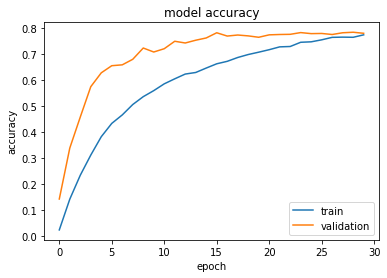

In [29]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()